# Predict Customer Loan Default Risk

<b>Andreea Nistor</b>

<b>&#x1F4C5; January 12th 2024</b>

## 	&#x26F3; 1. Bussines Understanding

### Project Overview
This project aims to develop a risk model to predict the likelihood of a customer defaulting on their credit card payments. We will use a classifier to determine which customers are likely to be unable to repay their balance within the next 12 months. The model will consider features such as loan amount, demographic data, repayment history, and balance information at various time points. The dataset used is the Default of Credit Card Clients Dataset (Taiwan, 2005), available on Kaggle at this [link](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/data).

### Output
- A `.ipynb file`.
- Model file (e.g., in pickle format) and an inference script.
- Relevant visualizations of the analysis within the notebook

### Questions & Answers 
1. How should customers with high vs. low default probability be treated? Is a simple score enough, or are calibrated probabilities needed?<br>
A: High-probability customers should be flagged for immediate action (e.g., offering repayment plans), while low-probability customers can be monitored. Although a simple score can be used, calibrated probabilities are preferred as they better reflect actual risk, enabling more informed decisions and targeted interventions.

2. What infrastructure is needed for deploying this model? Should a smaller CPU machine or a larger GPU-based one be used?<br>
A: A smaller CPU machine will suffice initially, but if more complex models are considered in the future, a machine with GPU support may be necessary. The primary focus should be on ensuring the accuracy of the predictions at this stage.

3. What are the costs associated with misclassifying a customer as likely to default vs. not likely to default?<br>
A: While default costs are not considered at this stage, if they were available, the goal would be to minimize misclassifications by applying a higher penalty for missed defaults to mitigate financial losses.

4. Which business metric or KPI will this prediction most impact?<br>
A: This model will most directly impact the default rate or delinquency rate, as accurate predictions can lead to proactive interventions, reducing defaults and improving profitability while minimizing financial risk.




## 	&#x26F3; Exploratory Data Analysis


Install the necessary libraries

In [52]:
# !pip install --quiet pandas scikit-optimize xgboost shap pywaffle graphviz seaborn

In [67]:
import pandas as pd # This library is used for data understanding and preparation
import os #To handle paths in a way that is portable
from sklearn.model_selection import train_test_split #To split the data into training and testing sets
from sklearn.metrics import confusion_matrix #Confusion matrix for model evaluation
from sklearn.metrics import classification_report, roc_curve, auc #For machine learning metrics
import xgboost as xgb #To train an xgboost classifier
import pickle #To save machine-learning models
from skopt import BayesSearchCV #For hyperparameter optimization
from skopt.space import Integer, Real #For the priories in hyperparameter optimization
import matplotlib.pyplot as plt #To make some plots
import numpy as np #To process some vectors
import shap #For explanability
from pywaffle import Waffle #This library is used for waffle plots
from graphviz import Digraph #To display the outline of the notebook
from IPython.display import Image #To display estimators of the XGBoost model
from typing import Union #To type the output of the function
from pandas import DataFrame #To type the output of the function

Notebook overview

In [55]:
# Company's brand colours
dark_blue = "#05becd"
light_blue = "#1fe0df"
black = "black"
dark_gray = "#1d1d1f"
gray = "gray"
light_gray = "#d3d3d3"
white = "white"

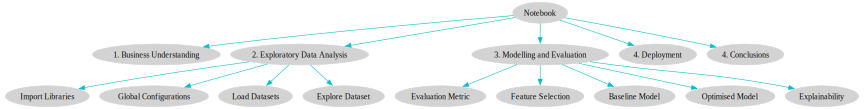

In [56]:
# Initialize a new directed graph
dot = Digraph(comment='Structure of the document')

# Set graph attributes
dot.attr(bgcolor=white)     # Set background color to black
dot.attr(size='12, 10')      # Set size of the graph
dot.attr(rankdir='TB')      # Top to bottom layout (default is TB)

# Set default node and edge attributes
dot.attr('node', style='filled', fillcolor=light_gray, fontcolor=black, color=light_gray)  # Dark blue text, light blue outline
dot.attr('edge', color=dark_blue)  # Light blue arrows

# Define the tree structure
dot.node('A', 'Notebook')                           # Root node
dot.node('B', '1. Business Understanding')          # First child of root
dot.node('C', '2. Exploratory Data Analysis')       # Second child of root
dot.node('D', '3. Modelling and Evaluation')        # Third child of root
dot.node('E', '4. Deployment')                      # Fourth child of root
dot.node('F', '4. Conclusions')                     # Fifth child of root

dot.node('C2', 'Import Libraries')                  # Child of Son 1
dot.node('C3', 'Global Configurations')             # Child of Son 1
dot.node('C4', 'Load Datasets')                     # Child of Son 1
dot.node('C5', 'Explore Dataset')                   # Child of Son 1

dot.node('D1', 'Evaluation Metric')                 # Child of Son 2
dot.node('D2', 'Feature Selection')                 # Child of Son 2
dot.node('D3', 'Baseline Model')                    # Child of Son 2
dot.node('D4', 'Optimised Model')                   # Child of Son 2
dot.node('D5', 'Explainability')                    # Child of Son 2


# Define edges between nodes to create hierarchy
dot.edge('A', 'B')              # Father -> Son
dot.edge('A', 'C')              # Father -> Son
dot.edge('A', 'D')              # Father -> Son
dot.edge('A', 'E')              # Father -> Son
dot.edge('A', 'F')              # Father -> Son

dot.edge('C', 'C2')              # Son -> Grandson
dot.edge('C', 'C3')              # Son -> Grandson
dot.edge('C', 'C4')              # Son -> Grandson
dot.edge('C', 'C5')              # Son -> Grandson

dot.edge('D', 'D1')              # Son -> Grandson
dot.edge('D', 'D2')              # Son -> Grandson
dot.edge('D', 'D3')              # Son -> Grandson
dot.edge('D', 'D4')              # Son -> Grandson
dot.edge('D', 'D5')              # Son -> Grandson


# Render and display the tree
display(dot)

Helper functions

In [ ]:
def plot_roc_curve(
    y_true: Union[list, np.ndarray], 
    y_pred_prob: Union[list, np.ndarray], 
    dataset: str
) -> None:
    """
    Plots the Receiver Operating Characteristic (ROC) curve for a given dataset.

    Args:
        y_true (Union[list, np.ndarray]): True binary labels.
        y_pred_prob (Union[list, np.ndarray]): Predicted probabilities for the positive class.
        dataset (str): Name of the dataset to include in the plot title.

    Returns:
        None
    """
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkblue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) ' + dataset.capitalize())
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


def missing_values_summary(df: DataFrame) -> DataFrame:
    """
    Summarizes columns in a DataFrame with significant missing values.

    Args:
        df (DataFrame): The input DataFrame to analyze.

    Returns:
        DataFrame: A DataFrame containing the count and percentage of missing values 
                   for columns with more than 70% missing data, sorted by percentage 
                   in descending order.

    The returned DataFrame has the following structure:
        - `Missing Values`: Total number of missing values per column.
        - `Percentage`: Percentage of missing values per column.
    """
    # Count total missing values for each column
    missing_count = df.isnull().sum()

    # Calculate percentage of missing values for each column
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    # Create a DataFrame summarizing the missing data
    missing_summary = pd.DataFrame({
        'Missing Values': missing_count,
        'Percentage': missing_percentage
    })

    # Filter only columns with missing data and sort by the most missing
    missing_summary = missing_summary[missing_summary['Percentage'] > 70]
    missing_summary = missing_summary.sort_values(by='Percentage', ascending=False)

    return missing_summary


### Load Dataset

Download <i>Default of Credit Card Clients Dataset</i> from Kaggle

In [ ]:
# # uncoment the following lines to download the dataset

# # Download the dataset
# !kaggle datasets download -d uciml/default-of-credit-card-clients-dataset
# # Create the ./data directory if it doesn't exist
# !mkdir -p ./data

# # Unzip the dataset into the ./data folder
# !unzip default-of-credit-card-clients-dataset.zip -d ./data

# # Delete the zip file
# !rm default-of-credit-card-clients-dataset.zip

In [58]:
path = 'data/UCI_Credit_Card.csv'
data = pd.read_csv(path)

### Explore Dataset

In [59]:
data.info()

# no missing values
# all columns are numerical
# target variable is 'default.payment.next.month'
# 30,000 rows and 25 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

&#x2757; In this dataset, there are no missing values. However, if missing data were present, it would be important to either remove or impute the missing values, depending on the dataset characteristics. 

&#x2757; The dataset consists of both numeric and categorical columns, but as the categorical columns (SEX, EDUCATION, MARRIAGE) are already encoded as integers, no further encoding is required for these features. However, if there were non-numeric factors in the future, techniques like one-hot encoding or LabelEncoder can be used.

In [60]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


&#x2757;	 The dataset variables have different scales. If using a model sensitive to feature scaling, standardize the values for consistent performance.

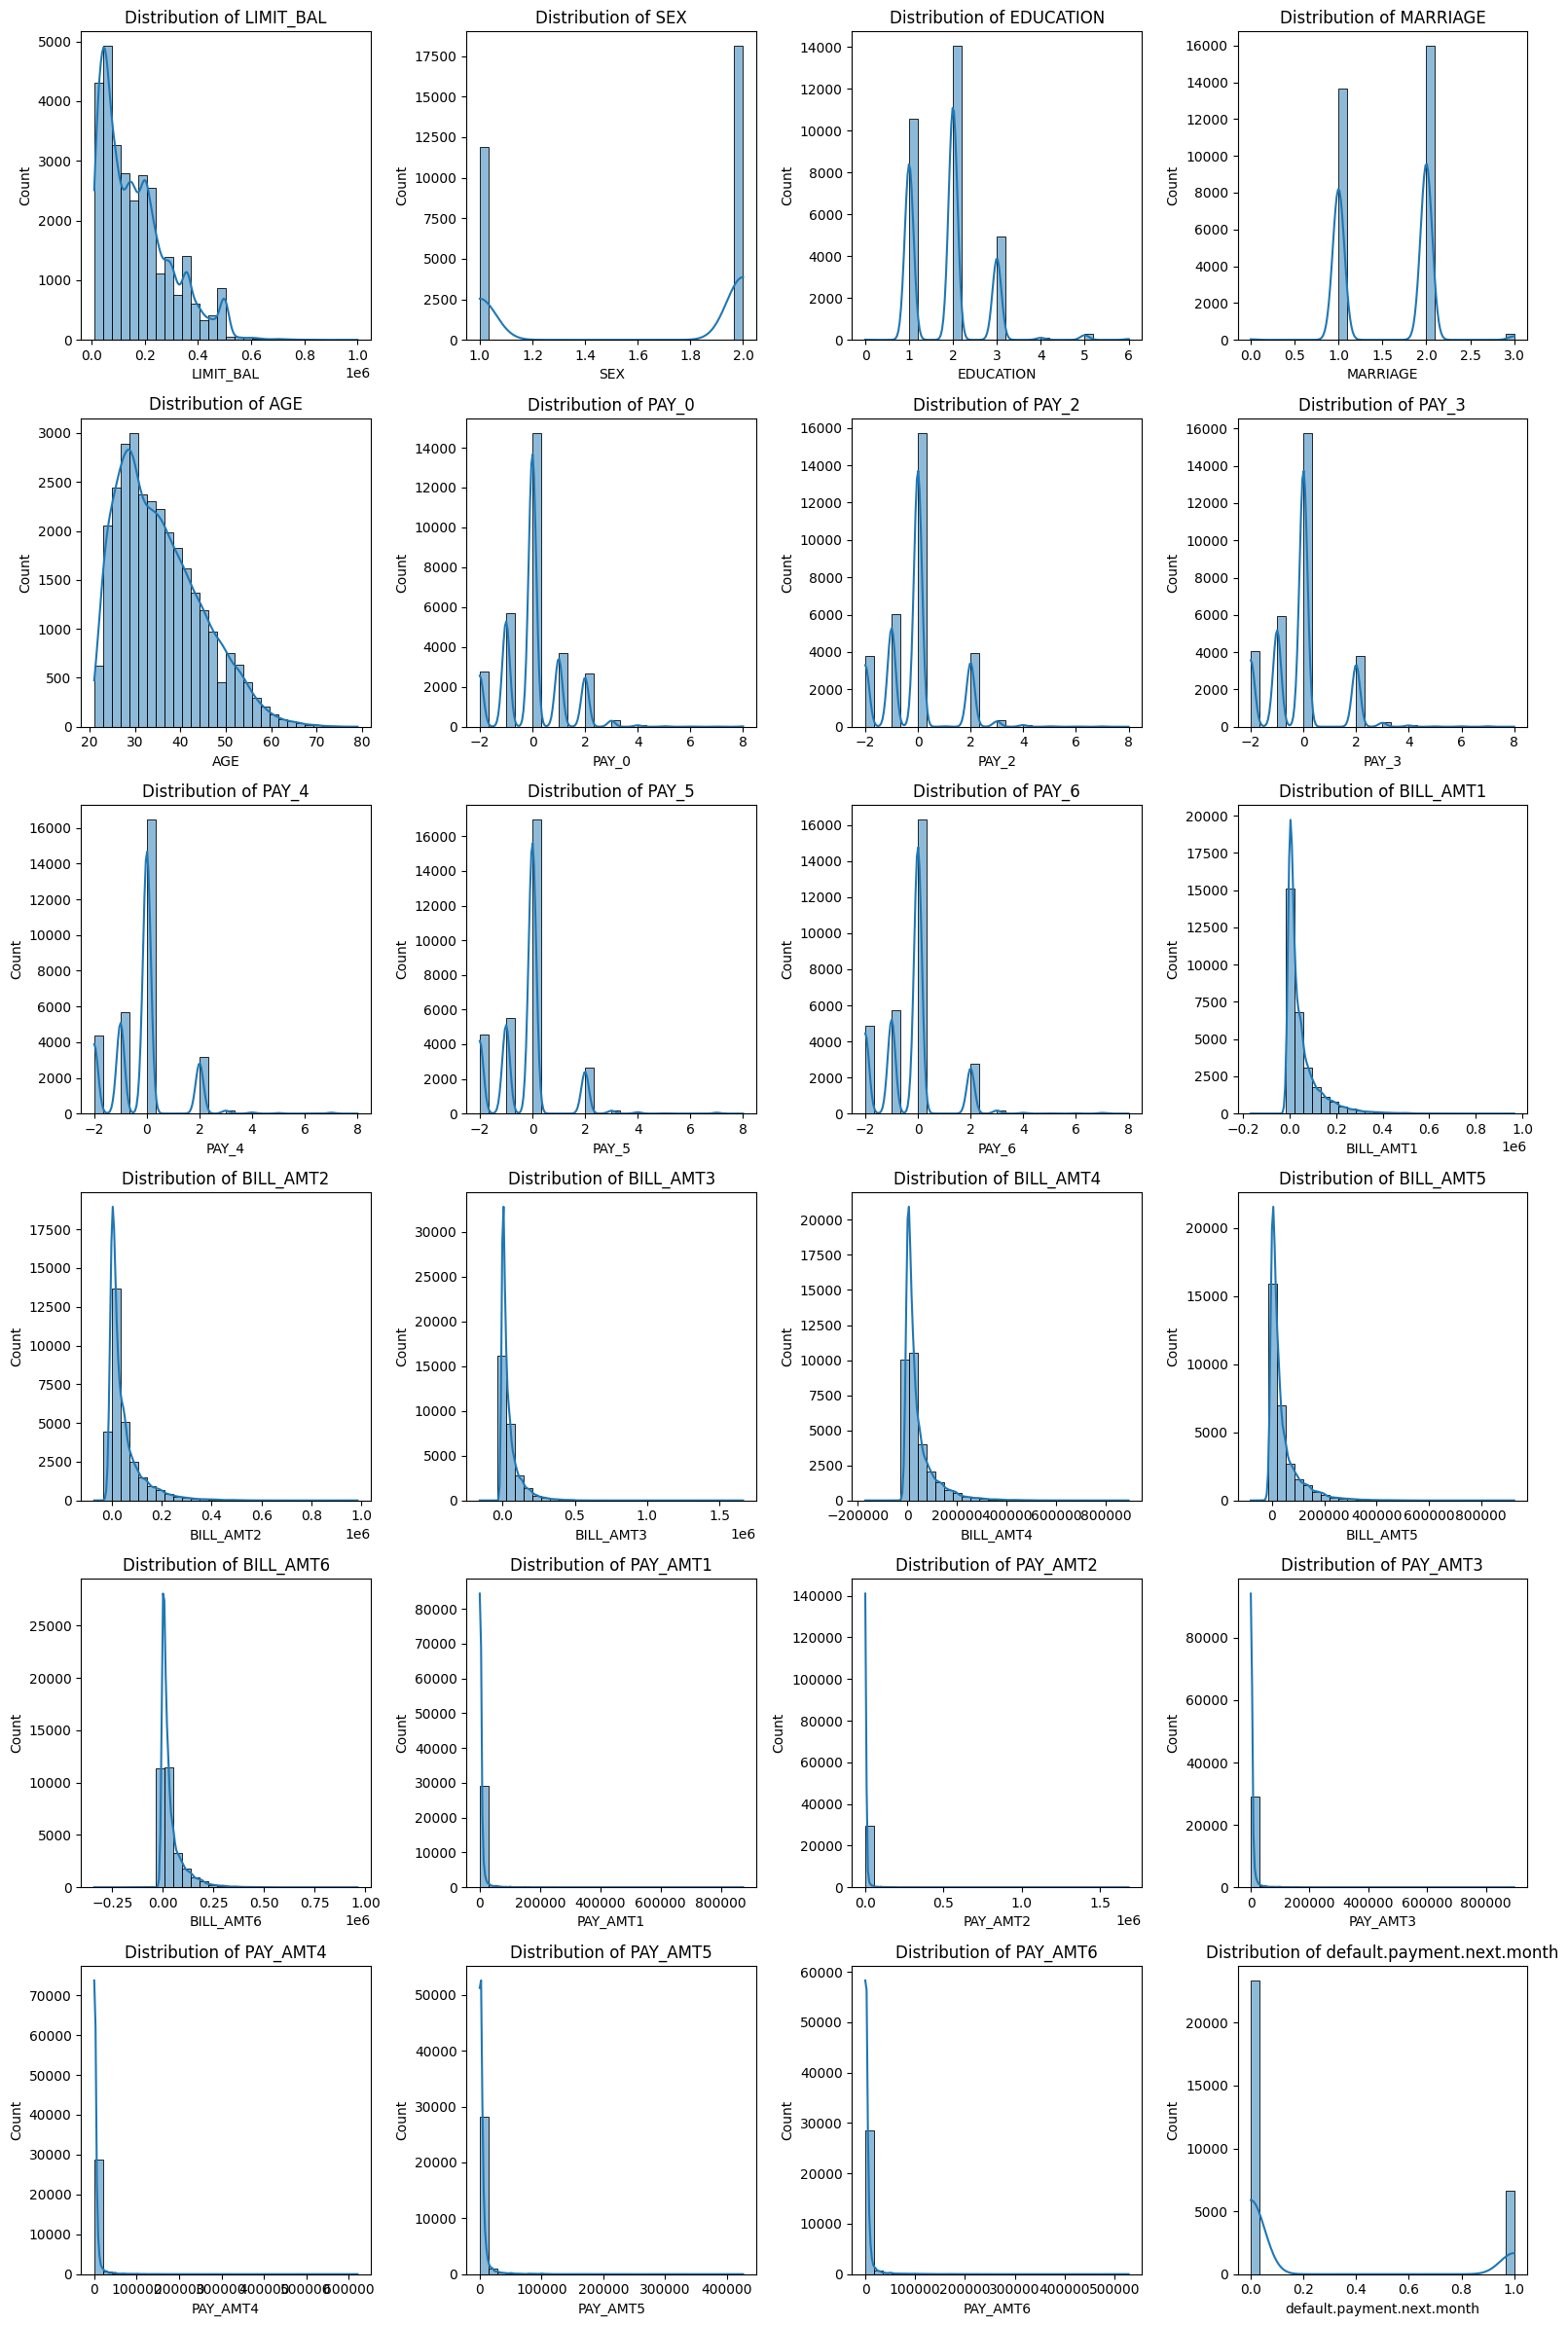

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming the dataset is in a DataFrame called df
# Exclude the 'ID' column
df_no_id = data.drop(columns=['ID'])

# Create a grid plot for all columns in the dataset (excluding 'ID')
num_columns = len(df_no_id.columns)
n_rows = (num_columns + 3) // 4  # To arrange in a grid with 4 columns

plt.figure(figsize=(16, 4 * n_rows))

# Loop through each column and plot its distribution
for i, column in enumerate(df_no_id.columns):
    plt.subplot(n_rows, 4, i + 1)
    sns.histplot(df_no_id[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()


The target variable in this dataset is imbalanced, and the feature data is positively skewed, with some negative values. These factors must be considered when selecting a model.

Decision tree-based models, like XGBoost and Random Forest, handle imbalanced data well and don’t require a normal distribution. XGBoost tends to be more precise in predictions and is optimized for fast training. However, Random Forest offers better interpretability. If interpretability becomes important, SHAP values can be used with XGBoost to determine feature importance ( [reference link](https://www.geeksforgeeks.org/difference-between-random-forest-vs-xgboost/) ). 

Given that this is a credit default predictive model, where precision and accuracy are more important than interpretability, XGBoost is my model of choice. It can effectively handle skewed features and imbalanced targets. While transformations like log or Box-Cox can improve performance and reduce training time, they’re not strictly necessary. For imbalanced targets, techniques like adjusting class weights, using SMOTE, or tweaking the scale_pos_weight parameter can help focus the model on the minority class, though these adjustments may not always be required.

This approach should help improve results in challenging datasets.

Split dataset into train and test sets

In [69]:
TARGET = 'default.payment.next.month'
cols_to_drop = [TARGET, 'ID']

X = data.drop(columns=cols_to_drop)  # Features (input variables)
y = data[TARGET]  # Target variable (label)

# Split the data into training and test sets, ensuring stratification on the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

In [70]:
X_train.shape, X_test.shape

((24000, 23), (6000, 23))

In [71]:
y_train.shape, y_test.shape

((24000,), (6000,))